OCR WITH KERAS

* All the discussion is on the Software Engineering Report item 5.1.

In [1]:
import cv2
import os
import numpy as np
import imutils
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imutils import build_montages
from PIL import Image

from models import ResNet
import matplotlib
matplotlib.use("Agg")

EPOCHS = 50
INIT_LR = 1e-1
BS = 128

Datasets:

A-Z
http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/

Load A-Z dataset:

In [2]:
def load_a_z_font_dataset(rootdir):
    data = []
    labels = []
    
    for (dirpath, dirnames, filenames) in os.walk(rootdir):
        for filename in filenames:
            
            labels.append(int(filename[8:11])-1)
            #print(int(filename[8:11])-11)
            
            image = cv2.imread(os.path.join(dirpath, filename))
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            (thresh, bwImage) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

            width, height = bwImage.shape
            totalpixels = width * height
            if cv2.countNonZero(bwImage) < totalpixels / 2:
                bwImage = np.invert(bwImage)

            (tH, tW) = bwImage.shape
            if tW > tH:
                bwImage = imutils.resize(bwImage, width=32)
            else:
                bwImage = imutils.resize(bwImage, height=32)

            (tH, tW) = bwImage.shape
            dX = int(max(0, 32 - tW) / 2.0)
            dY = int(max(0, 32 - tH) / 2.0)

            padded = cv2.copyMakeBorder(bwImage, top=dY, bottom=dY,
                left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                value=(255, 255, 255))

            data.append(padded)                    

    return (data, labels)

Loading:

In [3]:
(data, labels) = load_a_z_font_dataset(r'C:\Projetos\Mestrado\Project II\SourceCode\TextIdentificationService\datasets\a_z_font')

data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

data = np.expand_dims(data, axis=-1)
data /= 255.0

le = LabelBinarizer()

labels = le.fit_transform(labels)
ounts = labels.sum(axis=0)

Training assesment balance:

In [4]:
classTotals = labels.sum(axis=0)
classWeight = {}

for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]

(trainX, testX, trainY, testY) = train_test_split(data,
                                                  labels, test_size=0.20, stratify=labels, random_state=42)

Preparing to train:

In [76]:
aug = ImageDataGenerator(rotation_range=10, zoom_range=0.05, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.15, horizontal_flip=False, fill_mode="nearest")

print("[INFO] compiling model...")

opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
                     (64, 64, 128, 256), reg=0.0005)
                     
model.compile(loss="categorical_crossentropy",
              optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


C:\Users\alanc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Training:

In [77]:
print("[INFO] training network...")

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS), 
            validation_data=(testX, testY), 
            #steps_per_epoch=len(trainX),
            epochs=EPOCHS,
            class_weight=classWeight,
            verbose=1)

N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Trainning Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

model_path = r"C:\Projetos\Mestrado\Project II\SourceCode\TextIdentificationService\model\trained_ocr_full.model"
model.save(model_path, save_format="h5")

[INFO] training network...
Epoch 1/50


C:\Users\alanc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


375/375 [==============================] - 745s 2s/step - loss: 3.9536 - accuracy: 0.3173 - val_loss: 1.9762 - val_accuracy: 0.5670
Epoch 2/50
375/375 [==============================] - 760s 2s/step - loss: 2.0484 - accuracy: 0.6646 - val_loss: 1.4575 - val_accuracy: 0.6530
Epoch 3/50
375/375 [==============================] - 752s 2s/step - loss: 1.5032 - accuracy: 0.7489 - val_loss: 1.0219 - val_accuracy: 0.7720
Epoch 4/50
375/375 [==============================] - 751s 2s/step - loss: 1.2889 - accuracy: 0.7778 - val_loss: 0.9374 - val_accuracy: 0.7853
Epoch 5/50
375/375 [==============================] - 754s 2s/step - loss: 1.1894 - accuracy: 0.7950 - val_loss: 0.8792 - val_accuracy: 0.8065
Epoch 6/50
375/375 [==============================] - 752s 2s/step - loss: 1.1297 - accuracy: 0.8034 - val_loss: 0.8699 - val_accuracy: 0.7993
Epoch 7/50
375/375 [==============================] - 754s 2s/step - loss: 1.0834 - accuracy: 0.8097 - val_loss: 0.8210 - val_accuracy: 0.8137
Epoch 8/50

Network evaluation:

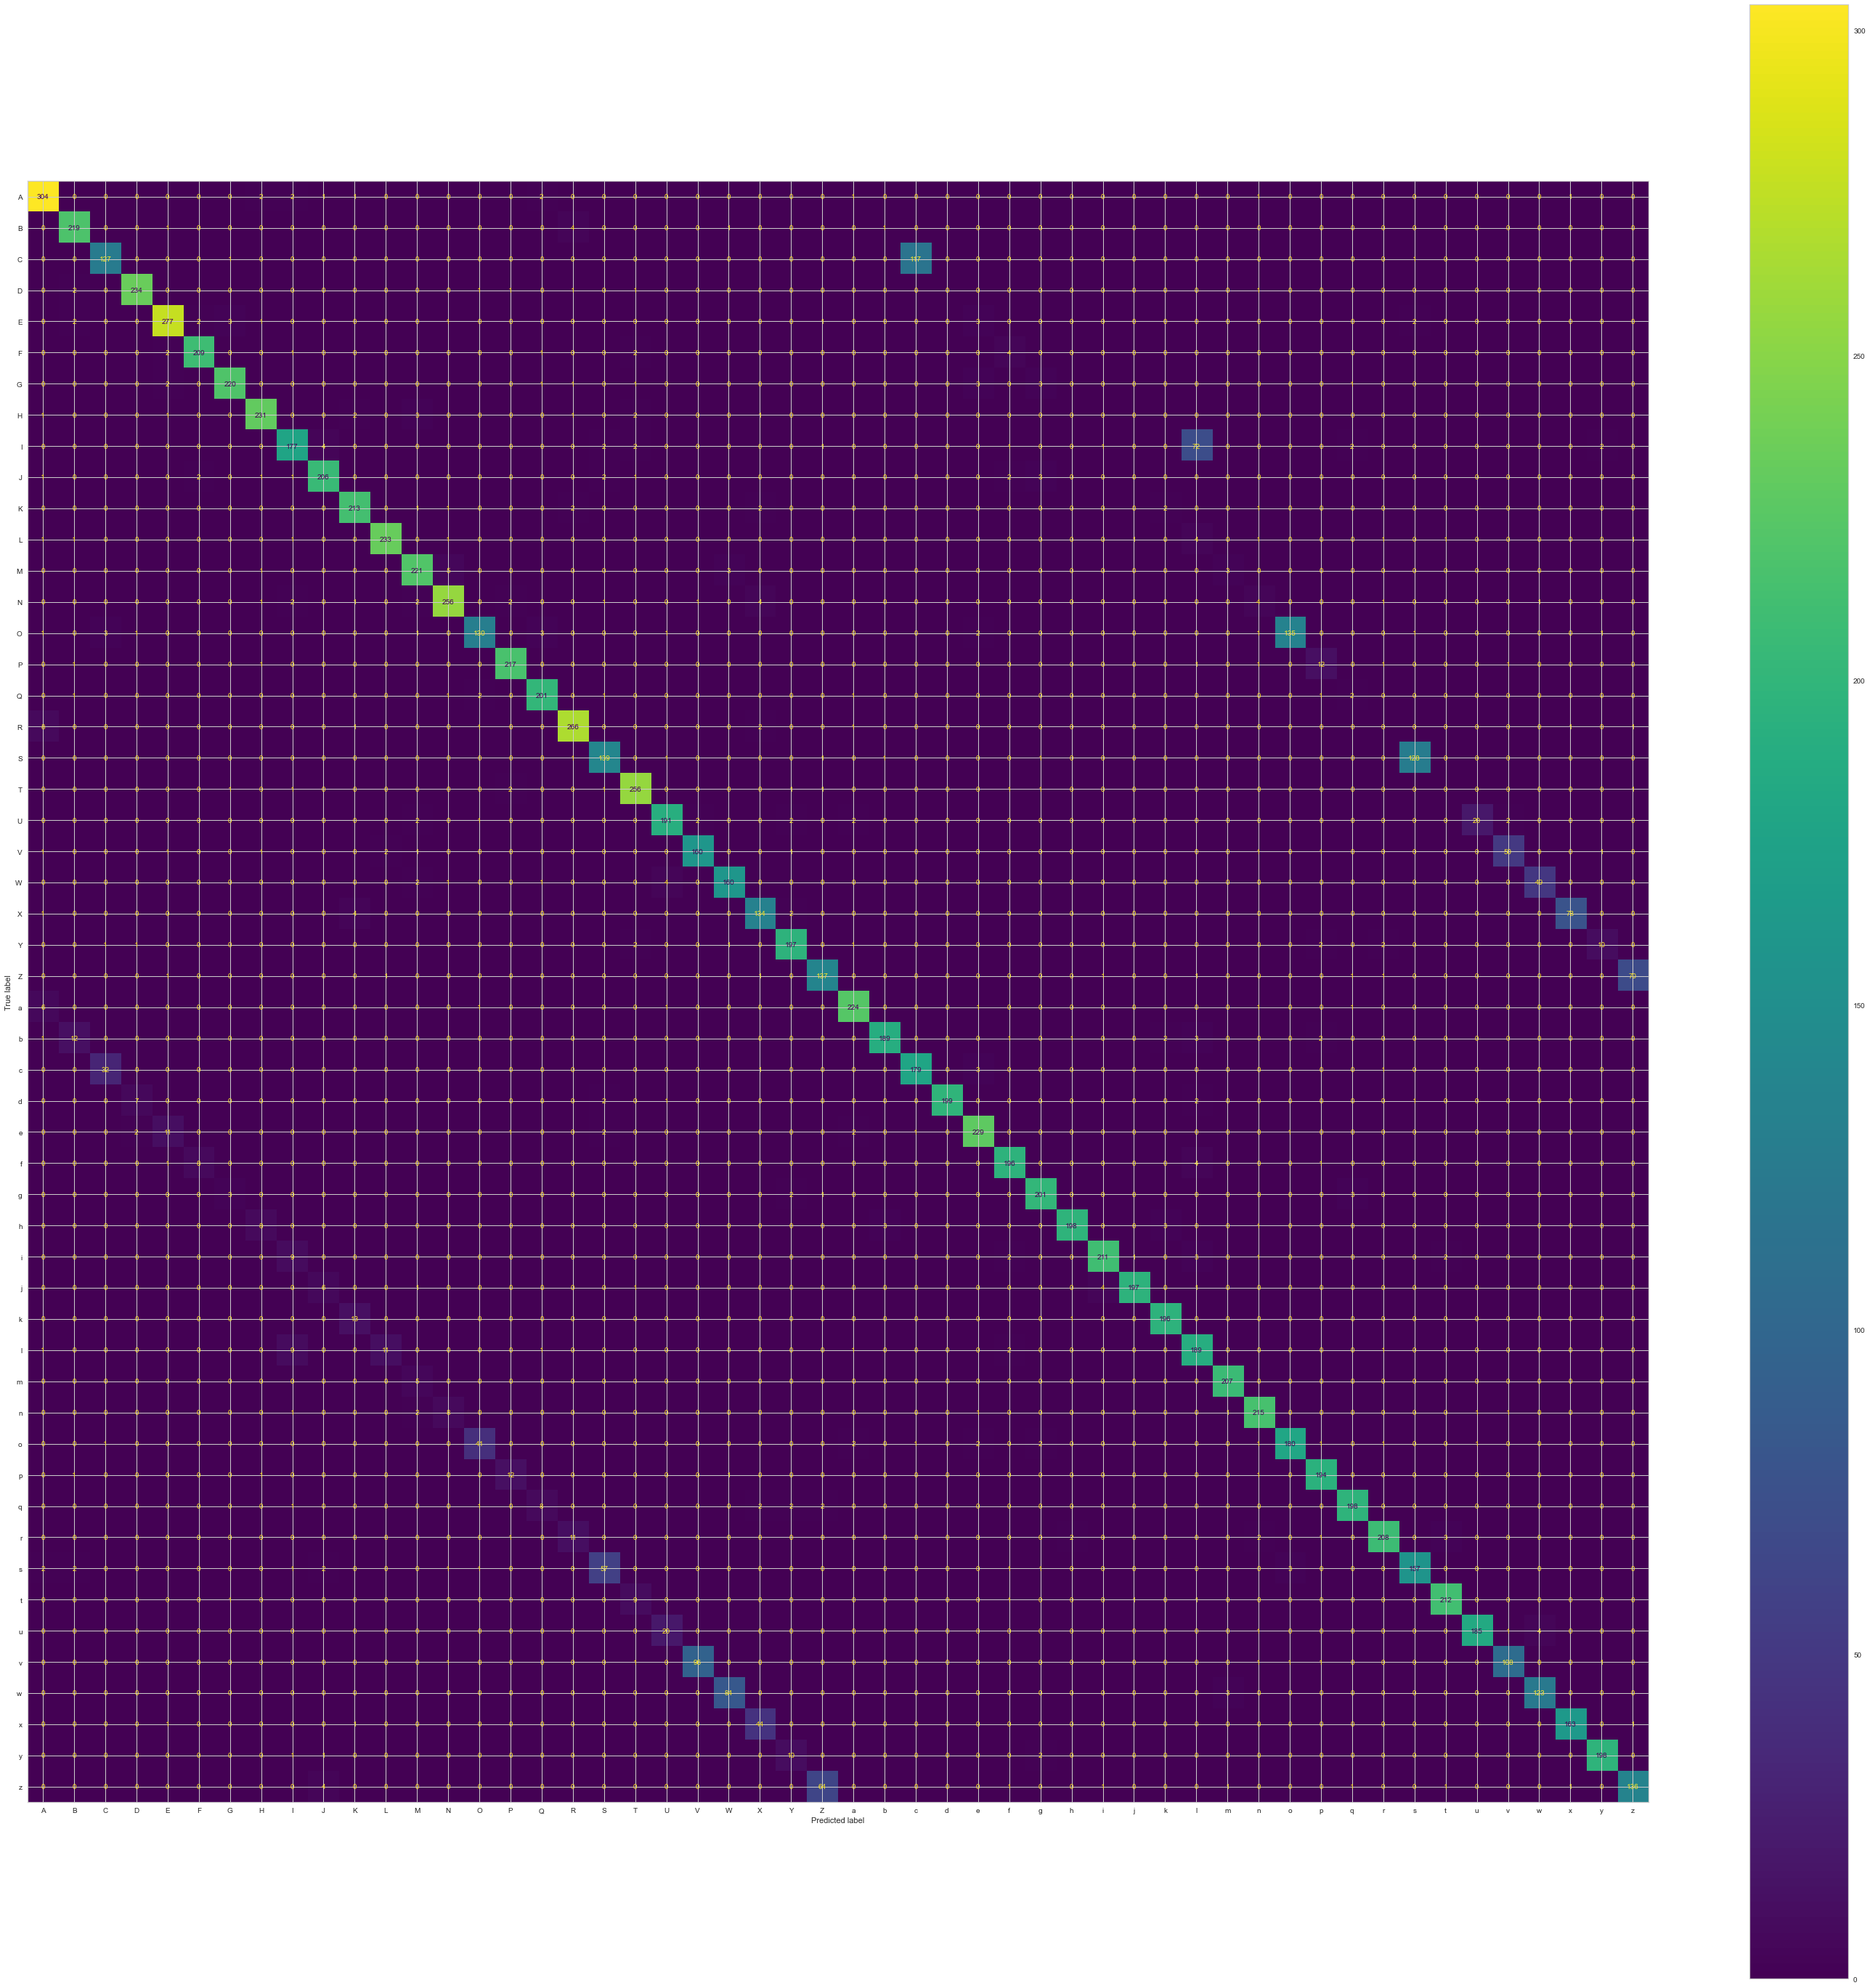

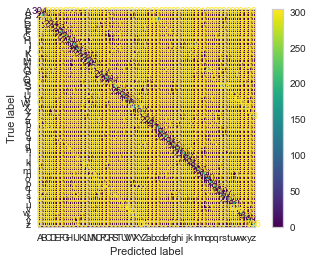

In [13]:
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

model_path = r"C:\Projetos\Mestrado\Project II\SourceCode\TextIdentificationService\model\trained_ocr_full.model"
model = load_model(model_path)

labelNames = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
labelNames = [l for l in labelNames]

predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

cm = confusion_matrix(testY.argmax(axis=1), predictions.argmax(axis=1))
f,ax = plt.subplots(1,1,figsize=(50,50))
cm_display = ConfusionMatrixDisplay.from_predictions(testY.argmax(axis=1), predictions.argmax(axis=1), display_labels=labelNames, ax=ax)

cm_display.plot()



Testing:

In [14]:
model_path = r"C:\Projetos\Mestrado\Project II\SourceCode\TextIdentificationService\model\trained_ocr_full.model"
model = load_model(model_path)

labelNames = "ACBDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
labelNames = [l for l in labelNames]

images = [] 
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
    probs = model.predict(testX[np.newaxis, i])
    prediction = probs.argmax(axis=1)
    label = labelNames[prediction[0]]
    #print(prediction)

    image = (testX[i] * 255).astype("uint8")
    color = (0, 255, 0)

    if prediction[0] != np.argmax(testY[i]):
        color = (0, 0, 255)

    image = cv2.merge([image] * 3)
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)

    images.append(image)

montage = build_montages(images, (96, 96), (7, 7))[0]

cv2.imshow("OCR Results", montage)
cv2.waitKey(0)

-1